In [1]:
# !pip install kaggle
# !pip install kagglehub
# 
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install Pillow
# !pip install scikit-learn
# 
# !pip install seaborn
# 
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install torchsummary

# !pip install joblib

# Setup

In [2]:
# Copy from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lantian773030/pokemonclassification")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\CindyHong\.cache\kagglehub\datasets\lantian773030\pokemonclassification\versions\1


In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import ImageOps,ImageEnhance
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import confusion_matrix
from torch.utils.data import random_split
import scipy

from torchvision import models
from sklearn.utils.class_weight import compute_class_weight

from joblib import dump, load
import gc


In [4]:
np.random.seed(2024)

# EDA (Exploratory Data Analysis)

In [5]:
# Setting dataset path
path = os.path.join(path,'PokemonData')
path

'C:\\Users\\CindyHong\\.cache\\kagglehub\\datasets\\lantian773030\\pokemonclassification\\versions\\1\\PokemonData'

In [10]:
class_list = pd.read_csv('class_sheet.csv')

In [11]:
class_list.columns,class_list.shape

(Index(['Pokemon', 'Winged', 'Not_Winged', 'Bad_Data'], dtype='object'),
 (150, 4))

### Observation: There are 150 pokemon characters in our dataset

.svg
.svg


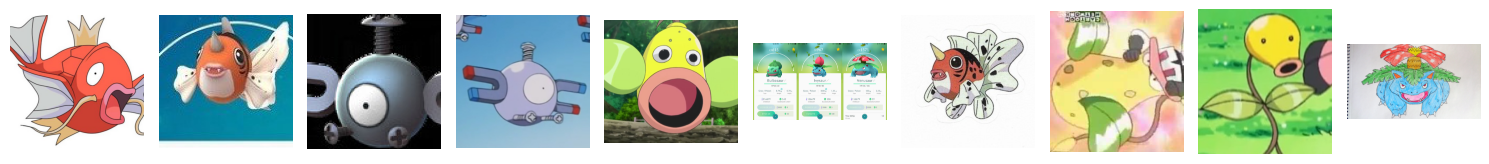

In [12]:
# Plotting 10 images of "bad data"
# Bad data refers to pokemon characters who are wingless species 
# but have features that is similar to wings
bad_class_list = class_list[class_list['Bad_Data'] == 1]['Pokemon']
bad_image_paths = []
valid_extensions = ['.jpg', '.jpeg', '.png']

for folder in bad_class_list:
    bad_image_names = os.listdir(os.path.join(path,folder))
    for image in bad_image_names:
        file_extension = os.path.splitext(image)[1]
        if file_extension not in valid_extensions:
            print(file_extension)
            continue
        bad_image_path = os.path.join(path,folder,image)
        bad_image_paths.append(bad_image_path)
bad_random_list = np.random.choice(bad_image_paths, 10, replace=False)

plt.figure(figsize=(15, 10))
for i,image_path in enumerate(bad_random_list):  
    with Image.open(image_path) as img:
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

### Observation: There are pokemon characters who are wingless species but have features that is similar to wings in our dataset. We can drop these "bad data" to make our work easier.

In [13]:
# Removing all classes with bad data
class_list = class_list[class_list['Bad_Data'] != 1]

In [14]:
# Getting Pokemons that are winged and not winged
winged = class_list[class_list['Winged'] == 1]
winged = winged['Pokemon']
not_winged = class_list[class_list['Not_Winged'] == 1]
not_winged = not_winged['Pokemon']

In [15]:
# Making a data frame that has the image paths and their classifcation
images = []
wrong_extensions = []

for folder in winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        if not os.path.exists(image_path):
            print(image_path)
            continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Winged'})
            
for folder in not_winged:
    image_names = os.listdir(os.path.join(path,folder))
    for image in image_names:
        file_extension = os.path.splitext(image)[1]
        # Sanity check to make sure all file paths exist
        if file_extension not in valid_extensions:
            wrong_extensions.append(file_extension)
            continue
        image_path = os.path.join(path,folder,image)
        if not os.path.exists(image_path):
            print(image_path)
            continue
        with Image.open(image_path) as img:
            img = np.array(img)
            images.append({'Image': img, 'Source': 'Not Winged'})
            
df = pd.DataFrame(images)
set(wrong_extensions)

{'.asp',
 ".jpg')",
 '.jpg~c200',
 '.sb-334870d9-FK2TVI',
 '.sb-334870d9-nlD60H',
 '.svg'}

### Observation: There are some image data in formats that can't be read by PIL(Python Imaging Library), so that we need to ignore them.

In [16]:
# Sanity check to make sure there are only 2 classes
for index, row in df.iterrows():
    if row['Source'] not in ['Winged', 'Not Winged']:
        print(row)

Dataframe shape: (6017, 2)
Source
Not Winged    5220
Winged         797
Name: count, dtype: int64


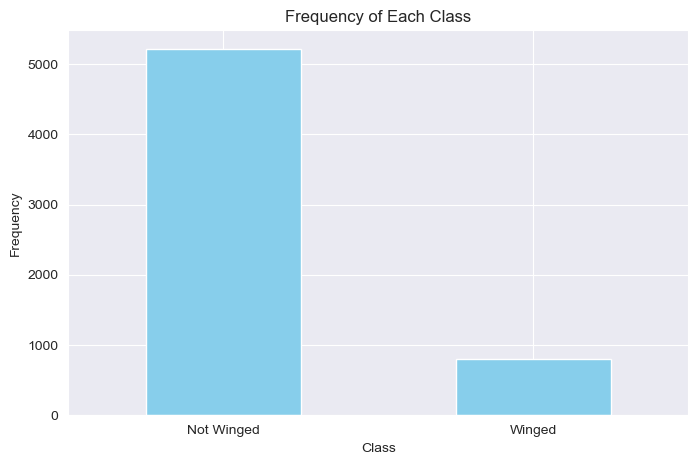

In [17]:
# Plotting frequencies of classes to check for data imbalance
source_counts = df['Source'].value_counts()
plt.figure(figsize=(8, 5))
source_counts.plot(kind='bar', color='skyblue')
plt.title("Frequency of Each Class")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)  
print("Dataframe shape:",df.shape)
print(source_counts)
plt.show()

### Observation: Not Winged class has way more examples than Winged, We'd either have to sample equal number of images from both sets or use a weight balanced optimizer

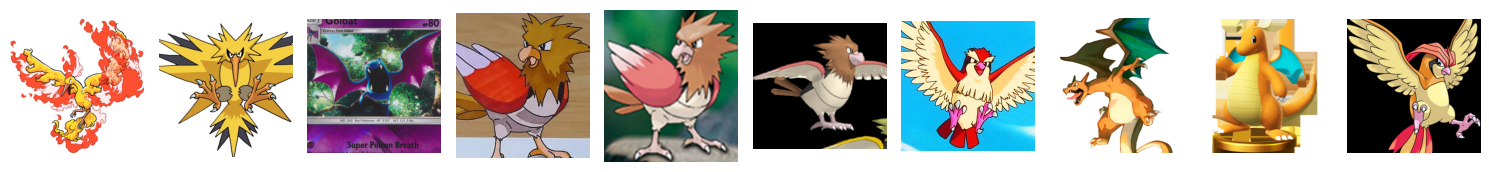

In [18]:
# plotting example classes of the winged image
Winged_random_list = np.random.choice(df[df['Source']=='Winged']['Image'], 10, replace=False)
plt.figure(figsize=(15, 10))
for i,img in enumerate(Winged_random_list):
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

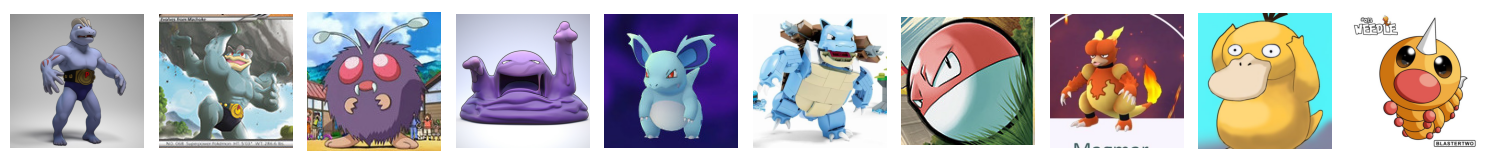

In [19]:
# plotting example classes of the not winged image
NWinged_random_list = np.random.choice(df[df['Source']=='Not Winged']['Image'], 10, replace=False)
plt.figure(figsize=(15, 10))
for i,img in enumerate(NWinged_random_list):
        plt.subplot(1, 10, i + 1)  
        plt.imshow(img)
        plt.axis('off')  
plt.tight_layout()
plt.show()

In [20]:
# Observing data shape
for i in np.random.choice(df['Image'].shape[0],size=10, replace=False):
    print(df['Image'][i].shape)

(874, 862, 3)
(800, 800, 3)
(1050, 1044, 3)
(875, 913, 3)
(126, 126, 3)
(480, 480, 3)
(219, 221, 3)
(881, 887, 3)
(503, 502, 3)
(789, 916, 3)


### Observation: Our image data consists of image tensors with a shape format of (height, width, RGB)

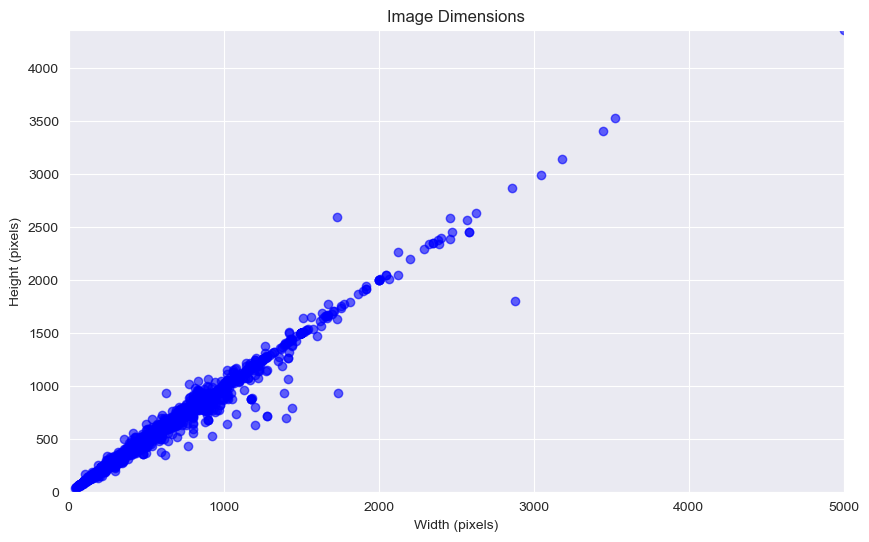

In [21]:
# Plotting the image pixel values
widths = []
heights = []

for img in df['Image']:
            widths.append(img.shape[1])
            heights.append(img.shape[0])

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, color='blue', alpha=0.6)
plt.title("Image Dimensions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.xlim(0, max(widths))  
plt.ylim(0, max(heights))  
plt.show()

### Observation: The dimensions of images are varying, we'd have to resize all of them to a common size

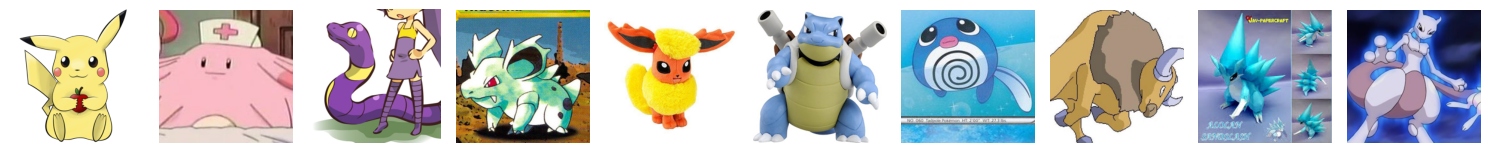

In [22]:
# Plotting 10 images after they've been resized
new_size = (224, 224)
resized_images = []

random_list = np.random.choice(df['Image'], 10, replace=False)

for img in random_list:
    resized_img = Image.fromarray(img).resize(new_size)
    resized_images.append(resized_img)

plt.figure(figsize=(15, 10))
for i, resized_img in enumerate(resized_images):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(resized_img)
    plt.axis('off')  
plt.tight_layout()
plt.show()

### Observation: After resizing, the image retains its prominent features, so we can expect a good fit. 

After ploting multiple random images of the Pokemon characters, we learned that the images of characters various in the style of visual representation.
- 3D rendering
- Plush photos
- Pokemon card
- Cartoon/anime
- Drawing
- Pokemon Go
- Realistic background
- Empty/single color background

### Therefore, we need to normalize the image data to eliminate the effect of different backgrounds on feature extraction.

There are also variations in the depictions of the pokemon:
- orientation
- shape
- for some pokemon, there may be special forms that make it hard to distinguish
- there is possibility for occlusion
- inclusion of English text

However, generally, the pokemon is centered in the image and is the main object.

# Data Preprocessing

In [23]:
# Normalizing function
def zscore(img,default = False):
    '''
    Apply Z-score normalization to an image.

    Parameters:
    - img (numpy array): The input image array.
    - default (bool): Whether to use default ImageNet mean and std.

    Returns:
    - img (numpy array): The normalized image array.
    '''
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        if not default:
            mean = img[:,:,c].mean()
            std = img[:,:,c].std()
        else:
            # Use default mean and std from ImageNet
            mean=[0.485, 0.456, 0.406][c]
            std=[0.229, 0.224, 0.225][c]
        if std > 0:
            img[:,:,c] = (img[:,:,c] - mean) / std
        else:
            img[:,:,c] = (img[:,:,c] - mean)
    return img

def minmax(img):
    '''
    Apply Min-Max normalization to an image.

    Parameters:
    - img (numpy array): The input image array.

    Returns:
    - img (numpy array): The normalized image array.
    '''
    img = img.astype(np.float32)
    for c in range(img.shape[2]):
        max = img[:,:,c].max()
        min = img[:,:,c].min()
        img[:,:,c] = (img[:,:,c] - min) / (max - min)
    return img

In [24]:
# Function to preprocess images
def preprocess(df, pattern, default=False, batch_size=50):
    '''
    Preprocess images by resizing, converting to grayscale or RGB, and normalizing pixel values.

    Parameters:
    - df (DataFrame): DataFrame containing images and labels.
    - pattern (str): Normalization pattern ('Zscore', 'Minmax', 'Grayscale').
    - default (bool): Whether to use default mean and std for Z-score normalization.
    - batch_size (int): Number of images to process in each batch.

    Returns:
    - X (numpy array): Array of preprocessed images.
    - y (numpy array): Array of corresponding labels.
    '''

    X = []
    y = []
    new_size = (224, 224)

     # Process images in batches to manage memory usage
    for start in range(0, len(df), batch_size):
        batch_df = df.iloc[start:start + batch_size]
        X_batch = []
        y_batch = []
        for _, row in batch_df.iterrows():
            # Resize images to 224 x 224
            img = Image.fromarray(row['Image']).resize(new_size)
            if pattern == 'Grayscale':
                # Convert images to grayscale
                img = img.convert('L')
                img = np.array(img) / 255.0
            else:
                img = img.convert('RGB')
                img = np.array(img)
                # Zscore normalization
                if pattern == 'Zscore':
                    img = zscore(img, default=default)
                # Minmax normalization
                elif pattern == 'Minmax':
                    img = minmax(img)

            X_batch.append(img)
            y_batch.append(1 if row['Source'] == 'Winged' else 0)
        
        X.append(np.array(X_batch))
        y.append(np.array(y_batch))
        
        # Release memory
        del X_batch, y_batch
        gc.collect()
    
    # Concatenate batches into full arrays
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y # X shape: (n_samples, 224, 224, 3) or (n_samples, 224, 224)

In [25]:
# Choose normalization pattern and preprocess images
pattern = 'Zscore'
X,y = preprocess(df[:50],pattern)
X.shape

(50, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

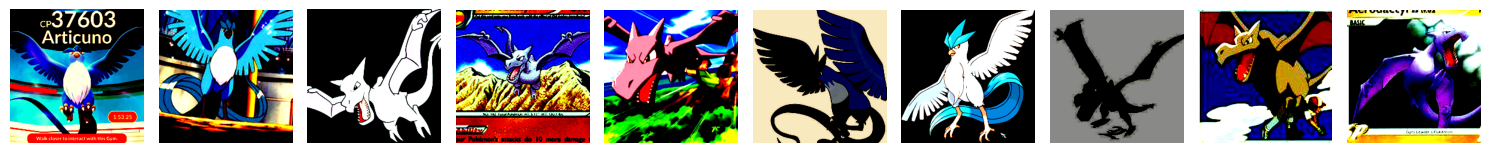

In [26]:
# Plotting 10 images after Zscore normalization
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [16]:
# Repeat the preprocessing with Min-Max normalization
pattern = 'Minmax'
X,y = preprocess(df[:50],pattern)
X.shape

(50, 224, 224, 3)

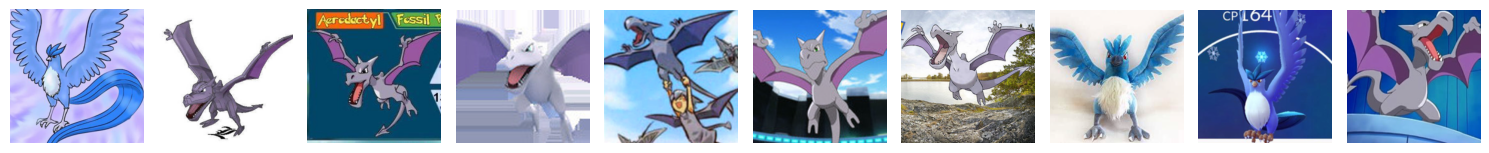

In [17]:
# Plotting 10 images after Min-Max normalization
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [18]:
# Repeat the preprocessing with Grayscale conversion
pattern = 'Grayscale'
X,y = preprocess(df[:50],pattern)
X.shape

(50, 224, 224)

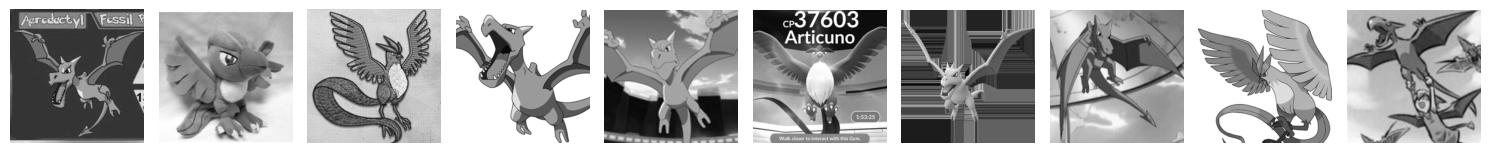

In [19]:
# Plotting 10 images after Grayscale
X_random_id = np.random.choice(X.shape[0], 10, replace=False)
X_random = X[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img,cmap="gray") 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [27]:
######## We can also use some optimization methods to train on imbalanced dataset ########
# Balancing the data set by random sampling
def random_sample(X,y,size=600):
    '''
    Balance the dataset by randomly sampling equal numbers of images from each class.

    Parameters:
    - X (numpy array): Array of images.
    - y (numpy array): Array of labels.

    Returns:
    - X (numpy array): Balanced array of images.
    - y (numpy array): Balanced array of labels.
    '''
    id_not_winged = np.where(y == 0)[0]
    id_winged = np.where(y == 1)[0]
    sample_not_winged = np.random.choice(id_not_winged, size, replace=False)
    sample_winged = np.random.choice(id_winged, size, replace=False)
    sample = np.concatenate((sample_not_winged, sample_winged), axis=0)
    X = X[sample]
    y = y[sample]
    return X,y
######## We can also use some optimization methods to train on imbalanced dataset ########

# Creating Train/Validate/Test splits (80/10/10)
def random_split(X,y,train_size=0.8):
    '''
    Split the data into training, validation, and test sets (80% train, 10% val, 10% test).

    Parameters:
    - X (numpy array): Array of images.
    - y (numpy array): Array of labels.

    Returns:
    - X_train, X_val, X_test: Split arrays of images.
    - y_train, y_val, y_test: Split arrays of labels.
    '''
    #Split into training and temporary sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-train_size, random_state=2024, stratify=y)

    #Split the temporary set into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2024, stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val,y_test

# X , y = random_sample(X,y)
# X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)

In [28]:
# Augmentation function
# Our resized image doesn't have enough space for shearing or zooming
def augmentation(img,pattern,img_size=(224,224),horizontal_flip=True,vertical_flip=False,rotation_range=20, horizontal_shift=0.2, vertical_shift=0.2):
    '''
    Apply data augmentation techniques to a single image.

    Parameters:
    - img (numpy array): Input image.
    - pattern (str): Normalization pattern used ('Zscore', 'Minmax', 'Grayscale').
    - img_size (tuple): Desired output image size.
    - horizontal_flip (bool): Whether to apply horizontal flip.
    - vertical_flip (bool): Whether to apply vertical flip.
    - rotation_range (int): Range of degrees for random rotations.
    - horizontal_shift (float): Fraction of width for horizontal shift.
    - vertical_shift (float): Fraction of height for vertical shift.

    Returns:
    - img (numpy array): Augmented image.
    '''
    if img.dtype == np.float32:
        # Convert image back to uint8 for PIL processing
        img = (img * 255).astype(np.uint8)
    if pattern != 'Grayscale':
        # Calculate mean pixel value for fill color
        mean = tuple(np.mean(img,axis=(0,1)).astype(int))
    else:
        mean = 0
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)

    # Apply horizontal flip with 50% probability
    if horizontal_flip and np.random.random() < 0.5:
        img = img.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

    # Apply vertical flip with 50% probability
    if vertical_flip and np.random.random() < 0.5:
        img = img.transpose(Image.Transpose.FLIP_TOP_BOTTOM)

    # Apply random rotation within the specified range
    if rotation_range > 0:
        rotation_range = np.random.randint(-rotation_range, rotation_range)
        img = img.rotate(rotation_range, resample=Image.BICUBIC,fillcolor=mean)

    # Apply random shifts
    if horizontal_shift > 0 or vertical_shift > 0:
        w , h = img_size
        dw = np.random.randint(-horizontal_shift * w, horizontal_shift * w)
        dh = np.random.randint(-vertical_shift * h, vertical_shift * h)
        img = ImageOps.expand(img, border=(abs(dw),abs(dh),abs(dw),abs(dh)),fill=mean)
        img = img.crop((dw+abs(dw),dh+abs(dh),dw+abs(dw)+w,dh+abs(dh)+h))
    # Ensure the image is resized back to the original dimensions
    img = img.resize(img_size)

    # Convert image back to numpy array and normalize pixel values
    img = np.array(img).astype(np.float32) / 255.0
    return img

In [29]:
# Going through all images and augment them
def augment_loop(X_train,y_train,pattern,img_size=(224,224),horizontal_flip=True,vertical_flip=False,rotation_range=20, horizontal_shift=0.2, vertical_shift=0.2):
    '''
    Apply augmentation to the training dataset.

    Parameters:
    - X_train (numpy array): Training images.
    - y_train (numpy array): Training labels.
    - pattern (str): Normalization pattern used.
    - img_size (tuple): Desired output image size.
    - Other parameters: Augmentation options.

    Returns:
    - X_train (numpy array): Augmented training images.
    - y_train (numpy array): Corresponding labels.
    '''
    
    X_augmented = []
    y_augmented = []
    for img, label in zip(X_train,y_train):
        X_augmented.append(img) # Original image
        img = augmentation(img,pattern,img_size,horizontal_flip,vertical_flip,rotation_range, horizontal_shift, vertical_shift)
        X_augmented.append(img) # Augmented image
        y_augmented.append(label)
        y_augmented.append(label)
    X_train = np.array(X_augmented)
    y_train = np.array(y_augmented)
    return X_train, y_train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


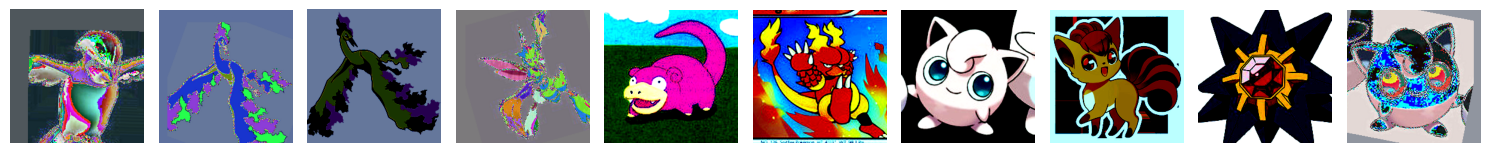

In [23]:
# Plotting 10 images after augmenting
pattern = 'Zscore'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y,size=10)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)
X_random_id = np.random.choice(X_train.shape[0], 10, replace=False)
X_random = X_train[X_random_id]
plt.figure(figsize=(15, 10))
for i, img in enumerate(X_random):
    plt.subplot(1, 10, i + 1)  
    plt.imshow(img) 
    plt.axis('off') 
plt.tight_layout()
plt.show()

In [24]:
# Check shapes of training, validation, and test sets
X_train.shape, X_val.shape, X_test.shape

((32, 224, 224, 3), (2, 224, 224, 3), (2, 224, 224, 3))

# Model Training

## ML

### Data Visualization

In [30]:
# Print classification report and Plot confusion matrix
def report_cm(model,X_train,y_train,X_val,y_val,X_test,y_test):
    '''
    Evaluate a machine learning model and plot confusion matrices.

    Parameters:
    - model: Trained machine learning model.
    - X_train, y_train: Training data and labels.
    - X_val, y_val: Validation data and labels.
    - X_test, y_test: Test data and labels.
    '''

    # Predictions on training data
    y_train_pred = model.predict(X_train)
    print(classification_report(y_train,y_train_pred))
    cm_train = confusion_matrix(y_train,y_train_pred)
    
    # Predictions on validation data
    y_val_pred = model.predict(X_val)
    print(classification_report(y_val,y_val_pred))
    cm_val = confusion_matrix(y_val,y_val_pred)
    
    # Predictions on test data
    y_test_pred = model.predict(X_test)
    print(classification_report(y_test,y_test_pred))
    cm_test = confusion_matrix(y_test,y_test_pred)
    
    # Plot confusion matrices
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Train')
    plt.subplot(1, 3, 2)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Val')
    plt.subplot(1, 3, 3)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Test')
    plt.show()


### Logistic Regression

In [31]:
# Preprocess data using Min-Max normalization
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [32]:
X_train.shape

(1920, 224, 224, 3)

In [33]:
# Flatten images for logistic regression
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

In [34]:
# Train logistic regression model
LR = LogisticRegression(max_iter=1000)
LR.fit(X_flattened_train, y_train)
dump(LR, 'LR.joblib')

['LR.joblib']

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00       960

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920

              precision    recall  f1-score   support

           0       0.54      0.57      0.55        60
           1       0.54      0.52      0.53        60

    accuracy                           0.54       120
   macro avg       0.54      0.54      0.54       120
weighted avg       0.54      0.54      0.54       120

              precision    recall  f1-score   support

           0       0.54      0.50      0.52        60
           1       0.53      0.57      0.55        60

    accuracy                           0.53       120
   macro avg       0.53      0.53      0.53       120
weighted avg       0.53      0.53      0.53       120



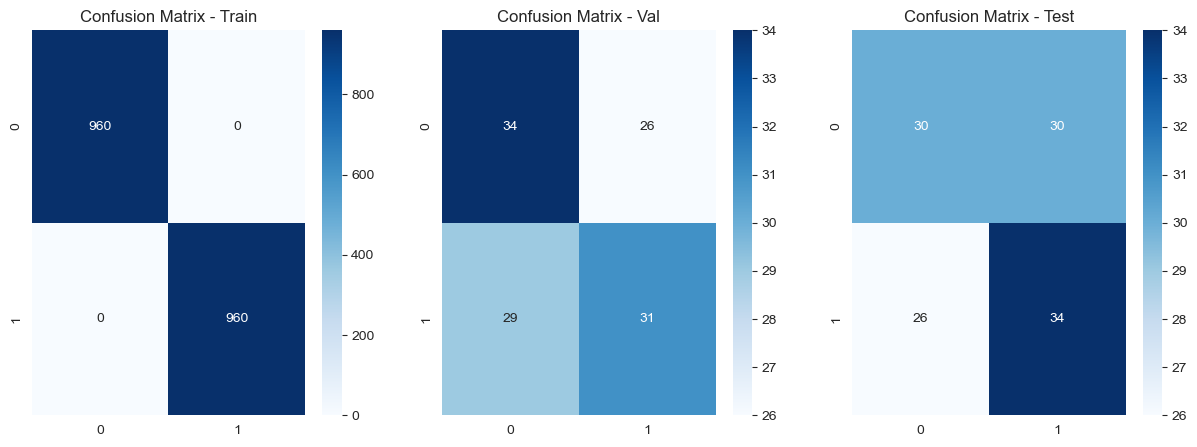

In [30]:
LR = load('LR.joblib')

# Evaluate the model
report_cm(LR,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)


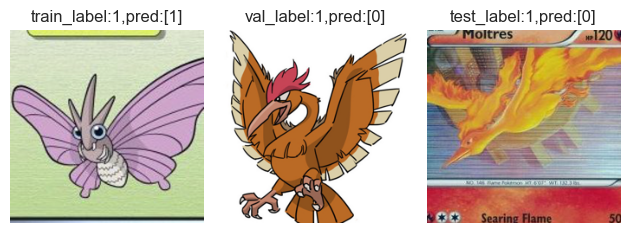

In [44]:
img = X_train[0]
plt.subplot(1, 3, 1)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'train_label:{y_train[0]},pred:{LR.predict(img.reshape(1, -1))}')
plt.tight_layout()
img = X_val[0]
plt.subplot(1, 3, 2)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'val_label:{y_train[0]},pred:{LR.predict(img.reshape(1, -1))}')
plt.tight_layout()
img = X_test[0]
plt.subplot(1, 3, 3)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'test_label:{y_train[0]},pred:{LR.predict(img.reshape(1, -1))}')
plt.tight_layout()
plt.show()

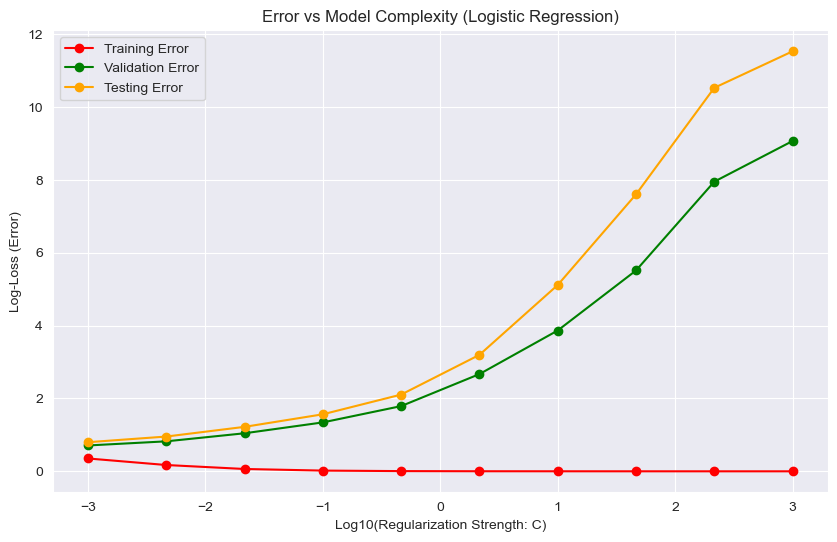

In [33]:
from sklearn.metrics import log_loss

complexity_values = np.logspace(-3, 3, 10)  # Regularization strength (C values)

train_errors = []
val_errors = []
test_errors = []

for complexity in complexity_values:
    # Set model complexity by adjusting the regularization strength
    LR.set_params(C=complexity)
    LR.fit(X_flattened_train, y_train)

    # Training error (log-loss)
    y_train_pred_prob = LR.predict_proba(X_flattened_train)
    train_error = log_loss(y_train, y_train_pred_prob)
    train_errors.append(train_error)

    # Validation error (log-loss)
    y_val_pred_prob = LR.predict_proba(X_flattened_val)
    val_error = log_loss(y_val, y_val_pred_prob)
    val_errors.append(val_error)

    # Testing error (log-loss)
    y_test_pred_prob = LR.predict_proba(X_flattened_test)
    test_error = log_loss(y_test, y_test_pred_prob)
    test_errors.append(test_error)

# Plot error vs complexity
plt.figure(figsize=(10, 6))
plt.plot(np.log10(complexity_values), train_errors, label="Training Error", marker="o", color="red")
plt.plot(np.log10(complexity_values), val_errors, label="Validation Error", marker="o", color="green")
plt.plot(np.log10(complexity_values), test_errors, label="Testing Error", marker="o", color="orange")
plt.title("Error vs Model Complexity (Logistic Regression)")
plt.xlabel("Log10(Regularization Strength: C)")
plt.ylabel("Log-Loss (Error)")
plt.legend()


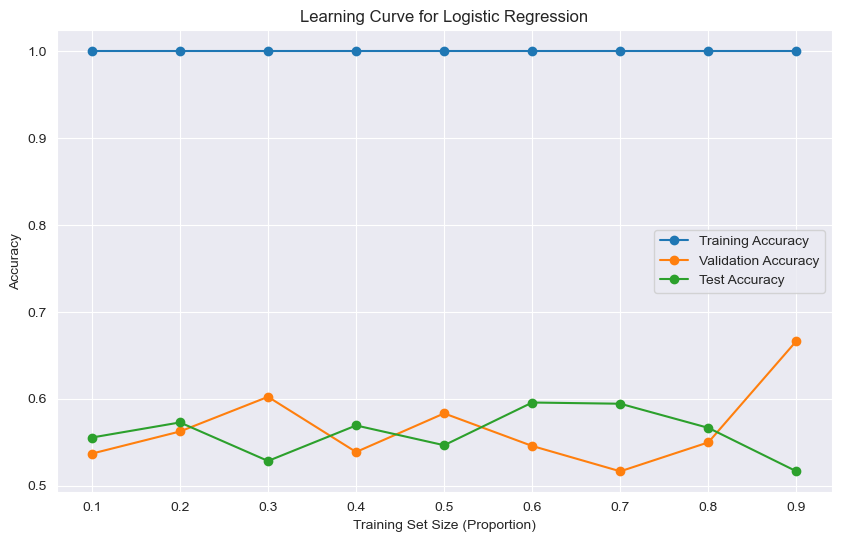

In [37]:
from sklearn.metrics import accuracy_score
train_sizes = np.linspace(0.1, 0.9, 9)
train_accuracies = []
val_accuracies = []
test_accuracies = []

for train_size in train_sizes:
    # Subsample the training data
    # Preprocess data using Min-Max normalization

    X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y,train_size=train_size)
    
    # X_train, y_train = augment_loop(X_train,y_train,pattern)
    
    # Flatten images for logistic regression
    X_flattened_train = X_train.reshape(X_train.shape[0], -1)
    X_flattened_val = X_val.reshape(X_val.shape[0], -1)
    X_flattened_test = X_test.reshape(X_test.shape[0], -1)
    
    # Train the model
    LR.fit(X_flattened_train, y_train)

    # Evaluate on the training set
    y_train_pred = LR.predict(X_flattened_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Evaluate on the validation set
    y_val_pred = LR.predict(X_flattened_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

    # Evaluate on the test set
    y_test_pred = LR.predict(X_flattened_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_accuracies, label="Training Accuracy", marker="o")
plt.plot(train_sizes, val_accuracies, label="Validation Accuracy", marker="o")
plt.plot(train_sizes, test_accuracies, label="Test Accuracy", marker="o")
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size (Proportion)")
plt.ylabel("Accuracy")
plt.legend()


The model is overfitting to the training data since the accurary is percent for training data, but it is less than 0.60 for validation and testing data. The logistic regression model is the first one we have trained, but it has shown that it is not a good model. Next, we will be building a SVM to see if we will be able to resolve the overfitting issue.

### SVM

In [20]:
pattern = 'Minmax'
X,y = preprocess(df,pattern)
X , y = random_sample(X,y)
X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y)
X_train, y_train = augment_loop(X_train,y_train,pattern)

In [21]:
X_flattened_train = X_train.reshape(X_train.shape[0], -1)
X_flattened_val = X_val.reshape(X_val.shape[0], -1)
X_flattened_test = X_test.reshape(X_test.shape[0], -1)

In [48]:
# Train SVM with RBF kernel
svm_rbf = SVC(kernel = 'rbf',probability=True,)
svm_rbf.fit(X_flattened_train, y_train)
dump(svm_rbf, 'svm_rbf.joblib')

['svm_rbf.joblib']

In [ ]:
svm_rbf = load('svm_rbf.joblib')

# Evaluate the model
report_cm(svm_rbf,X_flattened_train,y_train,X_flattened_val,y_val,X_flattened_test,y_test)

In [ ]:
img = X_train[0]
plt.subplot(1, 3, 1)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'train_label:{y_train[0]},pred:{svm_rbf.predict(img.reshape(1, -1))}')
plt.tight_layout()
img = X_val[0]
plt.subplot(1, 3, 2)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'val_label:{y_train[0]},pred:{svm_rbf.predict(img.reshape(1, -1))}')
plt.tight_layout()
img = X_test[0]
plt.subplot(1, 3, 3)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'test_label:{y_train[0]},pred:{svm_rbf.predict(img.reshape(1, -1))}')
plt.tight_layout()
plt.show()

In [26]:
svm_rbf = SVC(kernel = 'rbf',probability=True)

In [ ]:
img = X_train[0]
plt.subplot(1, 3, 1)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'train_label:{y_train[0]},pred:{svm_rbf.predict(img.reshape(1, -1))}')
plt.tight_layout()
img = X_val[0]
plt.subplot(1, 3, 2)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'val_label:{y_train[0]},pred:{svm_rbf.predict(img.reshape(1, -1))}')
plt.tight_layout()
img = X_test[0]
plt.subplot(1, 3, 3)
plt.imshow(img) 
plt.axis('off') 
plt.title(f'test_label:{y_train[0]},pred:{svm_rbf.predict(img.reshape(1, -1))}')
plt.tight_layout()
plt.show()

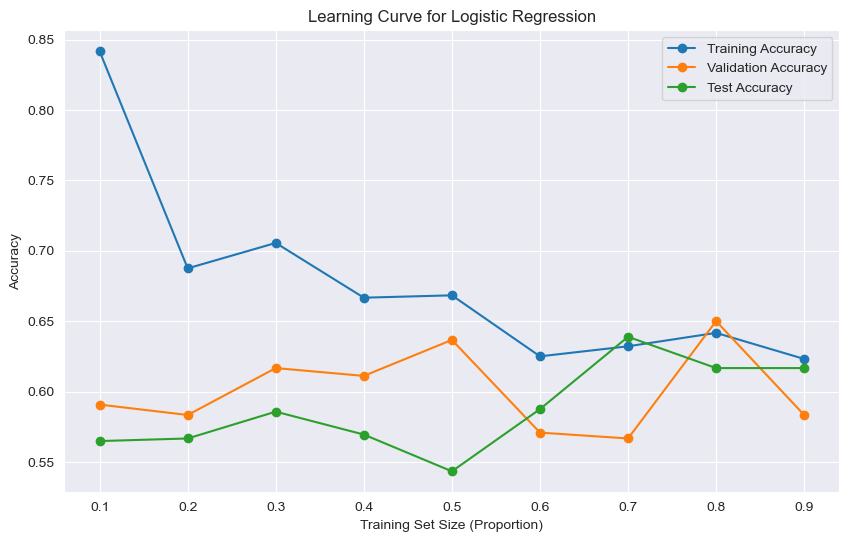

In [25]:
from sklearn.metrics import accuracy_score
train_sizes = np.linspace(0.1, 0.9, 9)
train_accuracies = []
val_accuracies = []
test_accuracies = []

for train_size in train_sizes:
    # Subsample the training data
    # Preprocess data using Min-Max normalization

    X_train, X_val, X_test, y_train, y_val,y_test = random_split(X,y,train_size=train_size)

    # X_train, y_train = augment_loop(X_train,y_train,pattern)

    # Flatten images for logistic regression
    X_flattened_train = X_train.reshape(X_train.shape[0], -1)
    X_flattened_val = X_val.reshape(X_val.shape[0], -1)
    X_flattened_test = X_test.reshape(X_test.shape[0], -1)

    # Train the model
    svm_rbf.fit(X_flattened_train, y_train)

    # Evaluate on the training set
    y_train_pred = svm_rbf.predict(X_flattened_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Evaluate on the validation set
    y_val_pred = svm_rbf.predict(X_flattened_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_accuracies.append(val_accuracy)

    # Evaluate on the test set
    y_test_pred = svm_rbf.predict(X_flattened_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_accuracies, label="Training Accuracy", marker="o")
plt.plot(train_sizes, val_accuracies, label="Validation Accuracy", marker="o")
plt.plot(train_sizes, test_accuracies, label="Test Accuracy", marker="o")
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size (Proportion)")
plt.ylabel("Accuracy")
plt.legend()


To classify if a pokemon is winged or not, we first built a logistic regression model without tuning any parameters. The logistic regression model is highly overfitted to the training data that it has a lower accuracy for testing and validation data. When we compare it to a model that predicts randomly, it has lower accuracy than the model. Thus, we moved on to build a SVM model to see if it will be a more generalized model. SVM is more robust to outliers. The performance of SVM measured by validation accuracy increased from 0.54 to 0.77. Something we can do to improve would be tuning the parameters of the model to find the sweet spot between complexity and accuracy. 

Next, we will be building a KNN model which is non-parametric. It does not have a training phase, so we can save on runtime and do not need to worry about hyperparameter tuning for the model.